<a href="https://colab.research.google.com/github/Abdulaziz0470/CNN-Recycling/blob/main/CNN_Image_Classification_(Recycling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Mounting Google Drive**


---


Importing all necessary libraries for deep learning, data augmentation, and evaluation. Mount Google Drive to access the dataset stored there.

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive, files
from PIL import Image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Define the Model**


---


Defining a deep learning model using MobileNetV2 (neural network architecture for image classification) as the base model with a few custom layers on top for classification. No fine-tuning is applied to MobileNetV2; only the custom layers are trainable.

In [16]:
# Define the model using MobileNetV2 (no fine-tuning here, keeping it simple!)
def create_model(num_classes=5):
    # Load MobileNetV2 with pre-trained weights, excluding the top classification layer
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze MobileNetV2 layers so we only train our custom layers

    # Add custom layers on top to adapt MobileNetV2 to classification task
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Flatten the output
        layers.Dense(512, activation='relu'),  # A fully connected layer with 512 units
        layers.Dropout(0.5),  # Dropout to help prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    # Compile the model: using a small learning rate because we’re working with pre-trained weights
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# **Initialize the Model**


---


Creating the model with the specified number of classes for classification.

In [17]:
# Create the model with the specified number of classes
num_classes = 5
model = create_model(num_classes=num_classes)

# **Data Augmentation and Data Generators**


---


Set up data augmentation to introduce variability into the training data, and create generators for both the training and validation sets. This helps improve the model’s ability to generalize.

In [18]:
# Setting up data augmentation and generators for training and validation
dataset_path = '/content/drive/MyDrive/Recycle Now!'  # Path to images
batch_size = 64  # Setting Batch number
img_height, img_width = 224, 224  # Image dimensions for MobileNetV2

# Setting the Augmantaitions for extra accuracy
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize pixel values to the range [0, 1] for better model performance, as the original range [0, 255] is too large!
    rotation_range=30,          # Randomly rotate images by up to 30 degrees to make the model robust to slight rotations in the input images
    width_shift_range=0.3,      # Randomly shift images horizontally by up to 30% of the width, adding variability and making the model resilient to positional changes
    height_shift_range=0.3,     # Randomly shift images vertically by up to 30% of the height, allowing the model to handle images where objects are slightly higher or lower
    shear_range=0.3,            # Apply random shearing transformations (skewing the image), helping the model generalize better with various perspectives
    zoom_range=0.3,             # Randomly zoom in or out by up to 30%, so the model can adapt to images that might be closer or farther away
    horizontal_flip=True,       # Randomly flip images horizontally to simulate mirror-image variations, improving the model’s robustness to left-right orientation changes
    fill_mode='nearest',        # Fill in any missing pixels that result from transformations by using the nearest pixel values to avoid black gaps or artifacts
    validation_split=0.1        # Set aside 10% of the data as a validation set to evaluate model performance without manual data splitting
)

# Load training and validation datasets with the specified augmentations
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),  # Resize all images to match MobileNetV2 input
    batch_size=batch_size,
    class_mode='sparse',  # Use sparse labels (integers) for our multi-class task
    subset='training'     # This subset is for training
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'  # This subset is for validation
)

Found 2152 images belonging to 5 classes.
Found 238 images belonging to 5 classes.


# **Display Class Names**


---


Print out the class names to verify the categories that the model will classify.

In [19]:
# Print out the class names to see what we're working with :)
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic']


# **Early Stopping Configuration**


---


Set up early stopping to monitor validation accuracy and prevent overfitting. Training will stop if validation accuracy does not improve after a specified number of epochs.

In [20]:
# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Watch validation accuracy to decide when to stop
    patience=5,              # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Go back to the best weights once training stops
)

# **Model Training Function**


---


Define a function to train the model, utilizing early stopping to halt training if no improvement in validation accuracy is observed.

In [21]:
# Training function that shows accuracy and loss for each epoch
def train_model(model, train_data, val_data, epochs=20):
    # Train the model with early stopping and print epoch-wise metrics
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping]  # Pass in early stopping callback to stop if needed
    )
    return history

# **Train the Model**


---


Train the model for a maximum of 15 epochs, but allow early stopping to intervene if validation accuracy stops improving.

In [22]:
# Train the model x epochs as a max, but will stop early if accuracy Stops Improving
history = train_model(model, train_generator, validation_generator, epochs=15)

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.3239 - loss: 1.6008 - val_accuracy: 0.7353 - val_loss: 0.8184
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 969ms/step - accuracy: 0.6044 - loss: 1.0115 - val_accuracy: 0.7353 - val_loss: 0.6539
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 930ms/step - accuracy: 0.6706 - loss: 0.8371 - val_accuracy: 0.7521 - val_loss: 0.6001
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 982ms/step - accuracy: 0.7081 - loss: 0.7627 - val_accuracy: 0.8235 - val_loss: 0.5316
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 938ms/step - accuracy: 0.7242 - loss: 0.7111 - val_accuracy: 0.7773 - val_loss: 0.5478
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 959ms/step - accuracy: 0.7579 - loss: 0.6598 - val_accuracy: 0.7983 - val_loss: 0.5443
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 943ms/step - accuracy: 0.7683 - loss: 0.6221 - val_accuracy: 0.7983 - val_loss: 0.5288
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 989ms/step - accuracy: 0.7804 - loss: 0.5873 - val_accurac

# **Plot Accuracy Over Epochs**


---

Define a function to visualize the training and validation accuracy across epochs. This plot helps to understand the model’s learning progress over time on both training and validation sets across each.

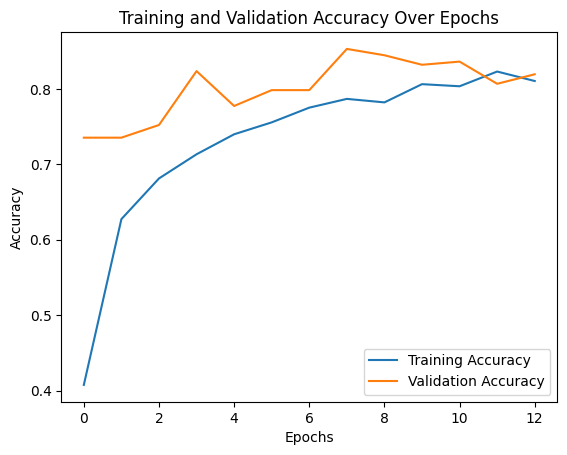

In [23]:
# Plotting the accuracy over each epoch
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Call the function to plot accuracy
plot_accuracy(history)

# **Model Evaluation and Classification Report**


---


Define a function to evaluate the model on the validation set. This function prints a detailed classification report for each class, along with the overall accuracy and average batch accuracy.

In [24]:
# Function to evaluate the model on the validation set and print classification report
def evaluate_model_with_report(model, val_data, class_names):
    # Get true labels and predictions
    true_labels = []
    predictions = []

    # Limit the loop to the exact number of validation batches
    steps = len(val_data)
    for i, (images, labels) in enumerate(val_data):
        if i >= steps:  # Stop after going through all batches in validation set
            break
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)
        true_labels.extend(labels)

    # Print the classification report
    print("\nClassification Report:\n")
    print(classification_report(true_labels, predictions, target_names=class_names))

    # Calculate and print the accuracy as a percentage
    correct_predictions = sum(np.array(true_labels) == np.array(predictions))
    accuracy = (correct_predictions / len(true_labels)) * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")

# **Evaluate the Model and Display Results**


---


Call the evaluation function to display the classification report and accuracy metrics for the model on the validation set after training.

In [25]:
# Evaluate the model on the validation set after training
evaluate_model_with_report(model, validation_generator, class_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.89      1.00      0.94        40
       glass       0.67      0.64      0.65        50
       metal       0.91      0.71      0.79        41
       paper       0.96      0.90      0.93        59
     plastic       0.67      0.81      0.74        48

    accuracy                           0.81       238
   macro avg       0.82      0.81      0.81       238
weighted avg       0.82      0.81      0.81       238


Overall Accuracy: 81.09%


# **Function to Display and Classify an Uploaded Image with Prediction Label**


---


This function allows users to upload an image, which the model then classifies and displays with the predicted label. The image is first loaded, resized to fit the model's input requirements, and preprocessed (scaled and expanded to match the expected dimensions). The model predicts the most likely class, and a confidence threshold is applied. If the confidence score for the top class is below the threshold (default 0.5), the image is labeled as "Undefined / UnRecyclable" to account for uncertain predictions. The function finally displays the image with the prediction as the title. This setup provides immediate visual feedback, Telling the user what type of Garbage they have.

Please upload an image for classification.


Saving WhatsApp Image 2024-10-28 at 21.23.59_952dee8c.jpg to WhatsApp Image 2024-10-28 at 21.23.59_952dee8c (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


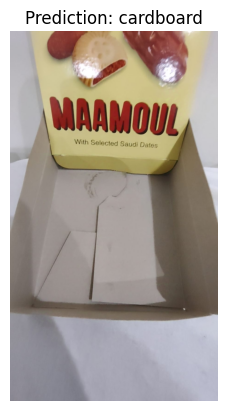

In [26]:
# Function to classify a single uploaded image and display it with prediction label
def classify_and_display_image(model, uploaded_image_path, class_names, confidence_threshold=0.5):
    # Load and preprocess the image
    image = Image.open(uploaded_image_path).convert('RGB')
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict the class of the image
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions[0])
    confidence_score = predictions[0][predicted_class]

    # Check if the confidence is above the threshold
    if confidence_score >= confidence_threshold:
        predicted_label = class_names[predicted_class]
    else:
        predicted_label = "Undefined / UnRecyclable"

    # Display the image with prediction label on top
    plt.imshow(np.array(Image.open(uploaded_image_path)))
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')
    plt.show()

# Upload and classify an image
print("Please upload an image for classification.")
uploaded = files.upload()

# Assuming a single image upload
uploaded_image_path = next(iter(uploaded))
classify_and_display_image(model, uploaded_image_path, class_names)